In [2]:
import numpy as np
import tensorflow as tf
from utility_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
mean = [2, 2]
matrix = [[0.2, 0], [0, 0.2]]
pst = np.random.multivariate_normal(mean, matrix, 500)

mean = [-2, -2]
matrix = [[0.2, 0], [0, 0.2]]
ngt = np.random.multivariate_normal(mean, matrix, 500)

tt = np.concatenate((pst,ngt), axis=0)

y1 = np.zeros(500)
y2 = np.ones(500)
y = np.concatenate((y1,y2),0)
y  = np.transpose(y)
y = np.reshape(y, (1000, ))

X_old = tt
Y_old = y
newcolors = np.array([[0/256, 0/256, 0/256, 1],
                   [256/256, 256/256, 256/256, 1]])
newcmp = ListedColormap(newcolors)

blockcolors = np.array([[256/256, 0/256, 0/256, 1],
                   [0/256, 0/256, 256/256, 1]])
blockcmp = ListedColormap(blockcolors)


(-7.0, 7.0)

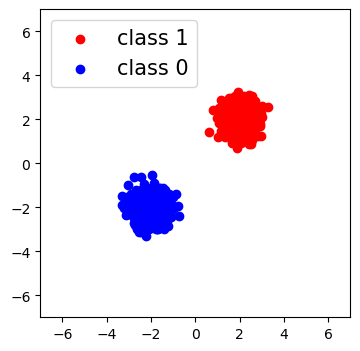

In [4]:
plt.figure(figsize=(4, 4))
plt.scatter(pst[:,0],pst[:,1],color='red')
plt.scatter(ngt[:,0],ngt[:,1],color='blue')

plt.legend(['class 1','class 0'],loc=2,fontsize = 15)
plt.ylim(-7,7)
plt.xlim(-7,7)


In [5]:
def create_VP2():
    xx = np.linspace(-7,7,30)
    yy = np.linspace(-7,7,30)
    X1,X2 = np.meshgrid(xx,yy)
    X1 = np.reshape(X1,[-1,1])
    X2 = np.reshape(X2,[-1,1])
    new_X = np.concatenate([X1,X2],axis = -1)

    new_Y = np.zeros([np.shape(new_X)[0]])+2
    return new_X, new_Y

new_X, new_Y = create_VP2()

X = np.concatenate([X_old,new_X], axis = 0)
Y = np.concatenate([Y_old,new_Y], axis = 0)

In [6]:
class BMF_loss(tf.keras.losses.Loss):
    def __init__(self, coeff, beta_func = 0):
        super().__init__()
        self.coeff = coeff
        self.beta_func = beta_func
    def call(self, y_true, y_pred):
        inp = y_true[:,1:]
        y_true = y_true[:,0]
        base = [1.0, 1.0, 0.0]
        indicator = tf.gather(base, indices = tf.cast(y_true,'int32'))
        alphas = tf.math.exp(y_pred)+1e-7
        inp_shape = tf.shape(inp)[0]
        zer = tf.zeros([inp_shape,1])

        betas = tf.ones_like(y_pred) * self.beta_func((inp))

        a_ans = tf.gather(tf.concat([alphas,zer],axis = -1),axis=-1, indices = tf.cast(y_true,'int32'), batch_dims = 1)
        a_zero = tf.math.reduce_sum(alphas,-1)
        beta_zero = tf.math.reduce_sum(betas,-1)
        
        l1_loss = indicator*(tf.math.digamma(a_ans) - tf.math.digamma(a_zero))


        loss1 = tf.math.lgamma(a_zero) - tf.math.reduce_sum(tf.math.lgamma(alphas), -1)
        loss1 += -tf.math.lgamma(beta_zero) + tf.math.reduce_sum(tf.math.lgamma(betas), -1)
        loss2 = tf.math.reduce_sum((alphas - betas)*(tf.math.digamma(alphas) - tf.math.digamma(tf.expand_dims(a_zero,-1))),-1)

        kl_loss = loss1 + loss2

        loss = tf.math.reduce_mean(self.coeff*kl_loss - l1_loss)
        return loss

In [11]:
coeff = 0.3
activation = 'relu'



def prior_exp(beta_func,coeff = coeff):
    model = tf.keras.Sequential ()
    model.add(tf.keras.layers.Dense(50, activation=activation, use_bias=True, input_shape=(2,)))
    model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = BMF_loss(coeff = coeff, beta_func = beta_func))

    model.fit(X,np.append(tf.expand_dims(Y, axis = -1),X[:,:],axis = 1),epochs = 50, verbose = 0)
    result,xx,yy = draw_prediction(model, xlim = [-7,7], ylim = [-7,7], num = [200,200])

    plt.show()
    return result

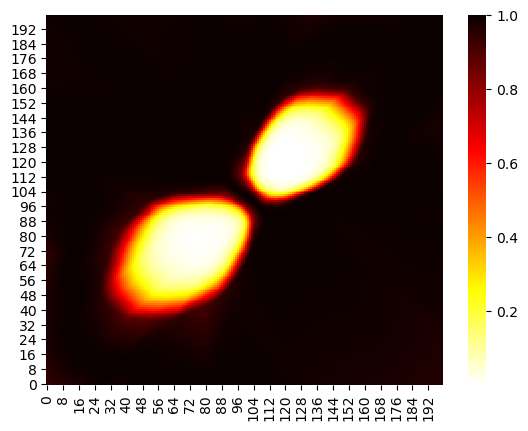

In [13]:
def squfunc(x):
    return tf.expand_dims(0.0003*tf.math.reduce_sum(x**2, axis = -1)+0.001, axis = -1)
result = prior_exp(squfunc)

import scipy
def entropy(x, use_sm = 1):
    if use_sm:
        x = scipy.special.softmax(x, axis = -1)
    e = np.zeros(len(x))
    for i,xi in enumerate(x):
        for j, xij in enumerate(xi):
            e[i] -=xij*np.log2(xij)
    return e

a = entropy(result)

ax = sns.heatmap(tf.reshape(a,[200,200]),cmap=cm.hot_r)
plt.gca().invert_yaxis()

plt.show()